In [2]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [4]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 6)


In [5]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler


In [6]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif


In [7]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
pd.options.display.float_format = '{:.2f}'.format


In [12]:
df = pd.read_csv(r"C:\Users\Amar\bank\bank-additional-full.csv", sep=';')


In [13]:
col_cat = list(df.select_dtypes(include=['object']).columns)
df.loc[:, col_cat] = df[col_cat].astype('category')


In [14]:
X = df.iloc[:,:-1]  #input columns
y = df.iloc[:,-1]    #target column 


In [15]:
col_cat.pop()
oe = OrdinalEncoder()
oe.fit(X[col_cat])
X_cat_enc = oe.transform(X[col_cat])
X_cat_enc = pd.DataFrame(X_cat_enc)
X_cat_enc.columns = col_cat


In [16]:
col_num = list(df.select_dtypes(include =['int64', 'float64']).columns)
scaler = MinMaxScaler(feature_range=(0, 1))
X_num_enc = scaler.fit_transform(X[col_num])
X_num_enc = pd.DataFrame(X_num_enc)
X_num_enc.columns = col_num
x_enc = pd.concat([X_cat_enc, X_num_enc], axis=1)


In [17]:
le = LabelEncoder()
le.fit(y)
y_enc = le.transform(y)
y_enc = pd.Series(y_enc)
y_enc.columns = y.name


In [18]:
col = list(x_enc.columns)
col.remove('emp.var.rate')
col.remove('nr.employed')
x_enc = x_enc[col]


In [19]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(x_enc,y_enc)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x_enc.columns)
featureScores = pd.concat([dfcolumns, dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
x_enc = x_enc[list(featureScores.nlargest(10,'Score')['Specs'])]
print(x_enc)
print(y_enc)

       euribor3m  contact  previous  duration  default  education  pdays  \
0           0.96     1.00      0.00      0.05     0.00       0.00   1.00   
1           0.96     1.00      0.00      0.03     1.00       3.00   1.00   
2           0.96     1.00      0.00      0.05     0.00       3.00   1.00   
3           0.96     1.00      0.00      0.03     0.00       1.00   1.00   
4           0.96     1.00      0.00      0.06     0.00       3.00   1.00   
...          ...      ...       ...       ...      ...        ...    ...   
41183       0.09     0.00      0.00      0.07     0.00       5.00   1.00   
41184       0.09     0.00      0.00      0.08     0.00       5.00   1.00   
41185       0.09     0.00      0.00      0.04     0.00       6.00   1.00   
41186       0.09     0.00      0.00      0.09     0.00       5.00   1.00   
41187       0.09     0.00      0.14      0.05     0.00       5.00   1.00   

       poutcome  job  cons.price.idx  
0          1.00 3.00            0.70  
1        

In [21]:
#Classifiers
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [22]:
clf = LogisticRegression()
scores = cross_val_score(clf, x_enc, y_enc, scoring='accuracy', cv=5)
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Logistic Regression'))

Accuracy: 0.87 (+/- 0.06) [Logistic Regression]


In [23]:
clf_name = ['Logistic Regression']
clf_acc = [scores.mean()]

In [24]:
clf1 = LogisticRegression(random_state=1)
clf2 = QuadraticDiscriminantAnalysis()
clf3 = GaussianNB()
clf4 = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
clf5 = AdaBoostClassifier()

for clf, label in zip([clf1, clf2, clf3, clf4, clf5], ['Logistic Regression', 'Quadratic Discriminant Analysis', 'naive Bayes', 'Random Forest', 'Ada Boost']):
     scores = cross_val_score(clf, x_enc, y_enc, scoring='accuracy', cv=5)
     print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.87 (+/- 0.06) [Logistic Regression]
Accuracy: 0.83 (+/- 0.13) [Quadratic Discriminant Analysis]
Accuracy: 0.80 (+/- 0.15) [naive Bayes]
Accuracy: 0.76 (+/- 0.24) [Random Forest]
Accuracy: 0.61 (+/- 0.27) [Ada Boost]


In [25]:
eclf = VotingClassifier(
     estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('rfc', clf4), ('abc', clf5)],
     voting='hard')
scores = cross_val_score(eclf, x_enc, y_enc, scoring='accuracy', cv=5)
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Hard Voiting Ensemble'))

Accuracy: 0.80 (+/- 0.15) [Hard Voiting Ensemble]


In [26]:
clf_name.append('Hard Voiting Ensemble')
clf_acc.append(scores.mean())

In [27]:
eclf = VotingClassifier(estimators=[
    ('logreg', clf1), 
    ('qda', clf2),
    ('nb', clf3), 
    ('rf', clf4), 
    ('ada', clf5)
], voting='soft')

# Perform cross-validation
scores = cross_val_score(eclf, x_enc, y_enc, scoring='accuracy', cv=5)

# Print the results
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Soft Voting Ensemble'))


Accuracy: 0.82 (+/- 0.15) [Soft Voting Ensemble]


In [28]:
clf_name.append('Soft Voiting Ensemble')
clf_acc.append(scores.mean())

In [29]:
X_train, X_test, y_train, y_test = train_test_split(x_enc, y_enc, test_size=0.33, random_state=1)
eclf.fit(X_train, y_train)
yhat = eclf.predict(X_test)

Training DataSet accuracy:  89.7% Test DataSet accuracy:  89.8%


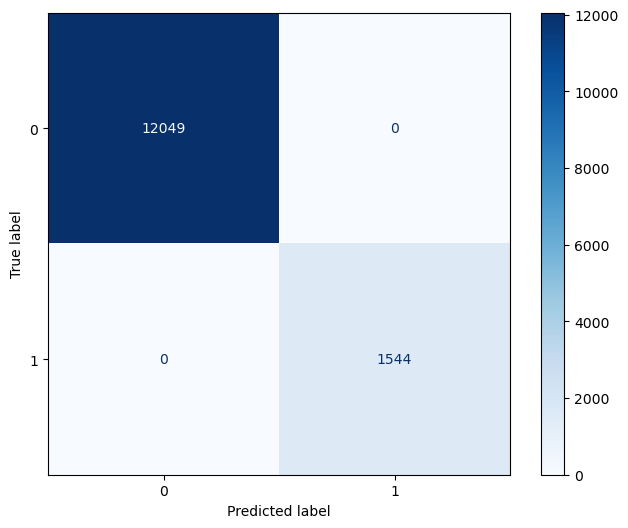

In [31]:
scores_train = eclf.score(X_train, y_train)
scores_test = eclf.score(X_test, y_test)
print('Training DataSet accuracy: {: .1%}'.format(scores_train), 'Test DataSet accuracy: {: .1%}'.format(scores_test))
cm = confusion_matrix(y_test, y_test)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

In [33]:
pip install tensorflow


   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/376.0 MB 6.7 MB/s eta 0:00:56
   ---------------------------------------- 1.8/376.0 MB 4.6 MB/s eta 0:01:22
   ---------------------------------------- 2.9/376.0 MB 4.3 MB/s eta 0:01:27
   ---------------------------------------- 3.7/376.0 MB 4.2 MB/s eta 0:01:29
   ---------------------------------------- 4.5/376.0 MB 4.2 MB/s eta 0:01:29
    --------------------------------------- 5.5/376.0 MB 4.1 MB/s eta 0:01:30
    --------------------------------------- 6.3/376.0 MB 4.1 MB/s eta 0:01:31
    --------------------------------------- 7.1/376.0 MB 4.1 MB/s eta 0:01:31
    --------------------------------------- 7.9/376.0 MB 4.1 MB/s eta 0:01:31
    --------------------------------------- 8.9/376.0 MB 4.0 MB/s eta 0:01:31
   - -------------------------------------- 9.7/376.0 MB 4.0 MB/s eta 0:01:31
   - -------------------------------------- 10.5/376.0 MB 4.0 MB/s eta 

In [36]:
pip install scikeras


Note: you may need to restart the kernel to use updated packages.


In [37]:
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical


In [41]:
def baseline_model():
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Only 1 output node
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [42]:
estimator = KerasClassifier(model=baseline_model, epochs=10, batch_size=5, verbose=1)
history = estimator.fit(X_train, y_train)


Epoch 1/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.8968 - loss: 0.2925
Epoch 2/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9069 - loss: 0.2172
Epoch 3/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9063 - loss: 0.2099
Epoch 4/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9110 - loss: 0.2088
Epoch 5/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9061 - loss: 0.2100
Epoch 6/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9085 - loss: 0.2058
Epoch 7/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9108 - loss: 0.2010
Epoch 8/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9095 - loss: 0.2058
Epoch 9/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9075 - loss: 0.2027
Epoch 10/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9091 - loss: 0.2014


Epoch 1/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8934 - loss: 0.2944
Epoch 2/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9082 - loss: 0.2174
Epoch 3/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9052 - loss: 0.2139
Epoch 4/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9075 - loss: 0.2085
Epoch 5/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9075 - loss: 0.2103
Epoch 6/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9084 - loss: 0.2074
Epoch 7/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9087 - loss: 0.2020
Epoch 8/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9077 - loss: 0.2078
Epoch 9/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9087 - loss: 0.2028
Epoch 10/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9094 - loss: 0.2046


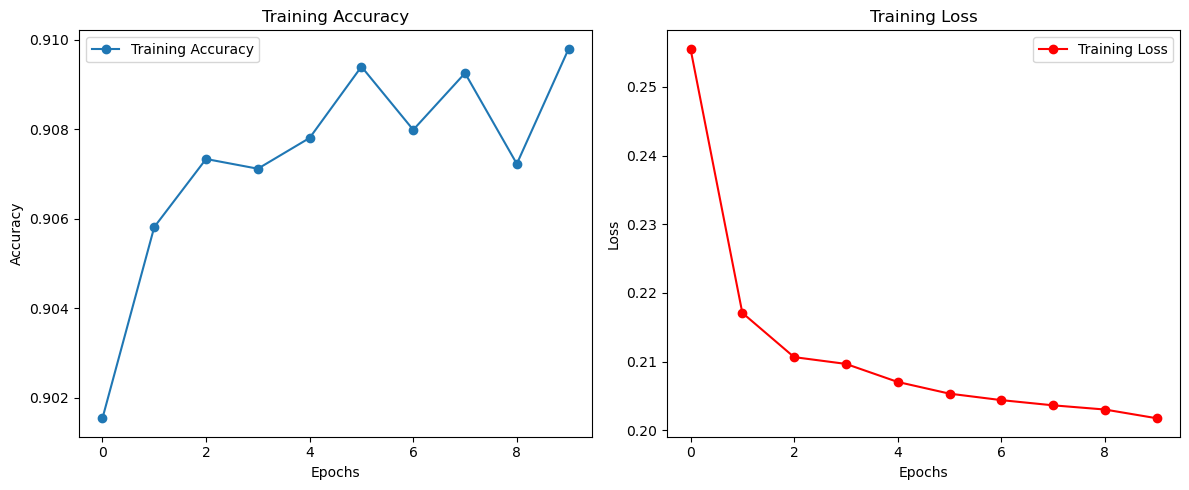

In [45]:
history = estimator.fit(X_train, y_train)
acc = history.history_['accuracy']
loss = history.history_['loss']

epochs_range = range(len(acc))  # Automatically adapts to number of epochs

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o', color='red')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [46]:
from sklearn.metrics import accuracy_score

In [47]:
yhat = estimator.predict(X_test)
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy))

2719/2719 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Accuracy: 0.91


In [48]:
clf_name.append('KerasClassifier')
clf_acc.append(accuracy)

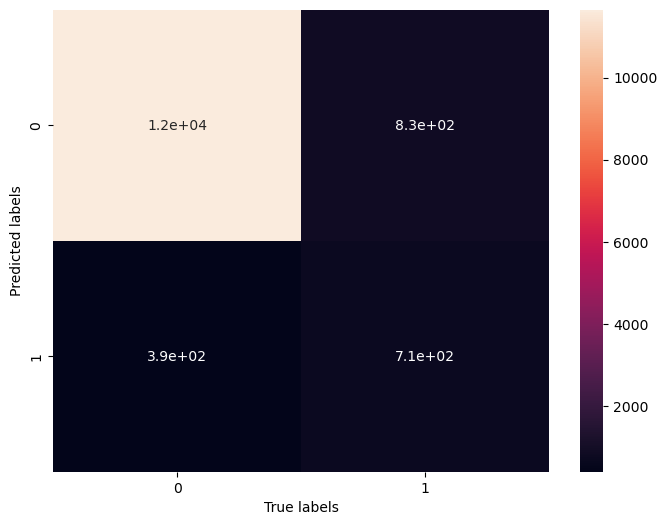

In [49]:
from sklearn.metrics import confusion_matrix
# Confusion matrix
cm = pd.DataFrame(confusion_matrix(yhat, y_test))
sns.heatmap(cm, annot=True, )
plt.xlabel("True labels")
plt.ylabel("Predicted labels")
plt.show()

In [53]:
from tensorflow.keras.models import save_model

n_members = 3
members = list()

for i in range(n_members):
    print(f"Training model {i+1}/{n_members}")
    
    # Define and fit model
    model = KerasClassifier(model=baseline_model, epochs=10, batch_size=5, verbose=1)
    model.fit(X_train, y_train)
    
    # Save the inner Keras model (model.model_ is the actual Keras model)
    model.model_.save(f'model_{i+1}.h5')
    
    # Keep reference to the full KerasClassifier if needed
    members.append(model)


Training model 1/3
Epoch 1/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9009 - loss: 0.2876
Epoch 2/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9070 - loss: 0.2157
Epoch 3/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9070 - loss: 0.2088
Epoch 4/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9072 - loss: 0.2107
Epoch 5/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9064 - loss: 0.2119
Epoch 6/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9096 - loss: 0.2059
Epoch 7/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9049 - loss: 0.2100
Epoch 8/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9088 - loss: 0.2032
Epoch 9/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9042 - loss: 0.2094
Epoch 10/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9078 - loss: 0.2007


Training model 2/3
Epoch 1/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8897 - loss: 0.2976
Epoch 2/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9075 - loss: 0.2171
Epoch 3/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9057 - loss: 0.2141
Epoch 4/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9122 - loss: 0.2027
Epoch 5/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9041 - loss: 0.2135
Epoch 6/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9101 - loss: 0.1997
Epoch 7/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9089 - loss: 0.2057
Epoch 8/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9078 - loss: 0.2066
Epoch 9/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9100 - loss: 0.2042
Epoch 10/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9112 - loss: 0.2017


Training model 3/3
Epoch 1/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8917 - loss: 0.3042
Epoch 2/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9073 - loss: 0.2161
Epoch 3/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9041 - loss: 0.2178
Epoch 4/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9063 - loss: 0.2125
Epoch 5/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9081 - loss: 0.2108
Epoch 6/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9071 - loss: 0.2077
Epoch 7/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9108 - loss: 0.2013
Epoch 8/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9086 - loss: 0.2044
Epoch 9/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9107 - loss: 0.2044
Epoch 10/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9098 - loss: 0.2018


In [54]:
# evaluate standalone models on test dataset
for model in members:
    yhat = model.predict(X_test)
    accuracy = accuracy_score(y_test, yhat)
    print('Accuracy: %.4f' % (accuracy))

2719/2719 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Accuracy: 0.9104
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Accuracy: 0.9089
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Accuracy: 0.9080


In [55]:
from numpy import dstack
def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
        # make prediction
        yhat = model.predict(inputX, verbose=0)
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat
        else:
            stackX = dstack((stackX, yhat))
    # flatten predictions to [rows, members]
    stackX = stackX.reshape((stackX.shape[1], stackX.shape[2]))
    return stackX

In [56]:
def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # fit standalone model
    model = LogisticRegression()
    model.fit(stackedX, inputy)
    return model

In [57]:
model = fit_stacked_model(members, X_test, y_test)

In [58]:
def stacked_prediction(members, model, inputX):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # make a prediction
    yhat = model.predict(stackedX)
    return yhat

In [59]:
yhat = stacked_prediction(members, model, X_test)
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.4f' % (accuracy))

Accuracy: 0.9093


In [60]:
clf_name.append('LinearKerasEnsemble')
clf_acc.append(accuracy)

In [61]:
df = pd.DataFrame({'Classificators':clf_name, 'Accuracy':clf_acc})
ax = df.plot.bar(x='Classificators', y='Accuracy', rot=45)

In [62]:
pd.options.display.float_format = '{:.4f}'.format
df

,Classificators,Accuracy
0,Logistic Regression,0.8695
1,Hard Voiting Ensemble,0.8041
2,Soft Voiting Ensemble,0.8237
3,KerasClassifier,0.9100
4,LinearKerasEnsemble,0.9093


In [65]:
for i, keras_model in enumerate(members):
    keras_model.model_.save(f"stacked_member_model_{i+1}.h5")


In [66]:
import joblib

joblib.dump(model, "meta_model.pkl")  # `model` is your stacking meta-learner


['meta_model.pkl']